In [1]:
!git clone https://github.com/Tanveer2719/NIDS_Coursework.git
%cd /kaggle/working/NIDS_Coursework/My_Code

Cloning into 'NIDS_Coursework'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 248 (delta 125), reused 207 (delta 84), pack-reused 0 (from 0)
Receiving objects: 100% (248/248), 205.71 KiB | 3.74 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/kaggle/working/NIDS_Coursework/My_Code


In [2]:
!ls /kaggle/input

nslkdd


In [3]:
import pandas as pd
import numpy as np

url_train = "/kaggle/input/nslkdd/KDDTrain+.txt"
url_test = "/kaggle/input/nslkdd/KDDTest+.txt"
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'attack', 'level'
]

train_df = pd.read_csv(url_train, names=columns)
test_df = pd.read_csv(url_test, names=columns)


# Drop the "type" column (not needed)
train_df.drop(columns=['level'], inplace=True)
test_df.drop(columns=['level'], inplace=True)

# Strip whitespace from class labels
for df in [train_df, test_df]:
    df['attack'] = df['attack'].str.strip()



# Combine train and test
full_df = pd.concat([train_df, test_df], ignore_index=True)

full_df['label'] = full_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
full_df = full_df.drop(columns=['attack'])

print(f'full_df.shape : {full_df.shape}')




# --------------------------- perform preprocessing--------------

from preprocess import Preprocess

# separate the features and labels so that the labesl are not encoded
labels = full_df['label']
features = full_df.drop(columns=['label'])

pp = Preprocess()
processed_features = pp.fit_transform_df_auto(df = features,n_categorical_levels=32, expected_categorical_format='onehot')

print(processed_features.shape)

# concat the features and the labels
processed_full_df = pd.concat([processed_features, labels], axis=1)


full_df.shape : (148517, 42)
Encoding the 3 levels for protocol_type
Encoding the 32 levels for service
Encoding the 11 levels for flag
(148517, 84)


In [4]:
# Filter out categorical one-hot encoded columns
numerical_columns = [col for col in processed_full_df 
                     if not (col.startswith("protocol_type_") or 
                             col.startswith("service_") or 
                             col.startswith("flag_") or
                             col == 'label')]

numerical_columns


['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [5]:
target = processed_full_df['label']
features = processed_full_df.drop(columns=['label'])

from record_level_embedding import RecordLevelEmbedder

embedder = RecordLevelEmbedder(selected_df = features, numerical_columns = numerical_columns, embed_dimension= 64)

embedded_df = embedder.transform_to_df()
embedded_df.head()


2025-08-04 05:33:20.505156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754285600.863815      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754285600.969796      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[INFO] Initializing RecordLevelEmbedder...
[INFO] Detecting categorical blocks...
[INFO] Detected 3 categorical blocks:
   - protocol_type: 3 columns
   - service: 32 columns
   - flag: 11 columns
[INFO] Embedder initialized with embedding dimension 64.
[INFO] Building Keras embedding model...
   - Adding numerical input: duration
   - Adding numerical input: src_bytes
   - Adding numerical input: dst_bytes
   - Adding numerical input: land
   - Adding numerical input: wrong_fragment
   - Adding numerical input: urgent
   - Adding numerical input: hot
   - Adding numerical input: num_failed_logins
   - Adding numerical input: logged_in
   - Adding numerical input: num_compromised
   - Adding numerical input: root_shell
   - Adding numerical input: su_attempted
   - Adding numerical input: num_root
   - Adding numerical input: num_file_creations
   - Adding numerical input: num_shells
   - Adding numerical input: num_access_files
   - Adding numerical input: num_outbound_cmds
   - Addin

I0000 00:00:1754285618.281835      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754285618.282485      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


[INFO] Projection complete. Output embedding shape: (64,)
[INFO] Model build complete.
[INFO] Preparing inputs for embedding. Number of rows: 148517
   - Prepared numerical input: duration
   - Prepared numerical input: src_bytes
   - Prepared numerical input: dst_bytes
   - Prepared numerical input: land
   - Prepared numerical input: wrong_fragment
   - Prepared numerical input: urgent
   - Prepared numerical input: hot
   - Prepared numerical input: num_failed_logins
   - Prepared numerical input: logged_in
   - Prepared numerical input: num_compromised
   - Prepared numerical input: root_shell
   - Prepared numerical input: su_attempted
   - Prepared numerical input: num_root
   - Prepared numerical input: num_file_creations
   - Prepared numerical input: num_shells
   - Prepared numerical input: num_access_files
   - Prepared numerical input: num_outbound_cmds
   - Prepared numerical input: is_host_login
   - Prepared numerical input: is_guest_login
   - Prepared numerical input: 

I0000 00:00:1754285620.438501     111 service.cc:148] XLA service 0x7baff0013940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754285620.439715     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754285620.439733     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754285620.493692     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  54/4642 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step  

I0000 00:00:1754285620.885584     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4642/4642 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
[INFO] Embedding complete. Output shape: (148517, 64)
[INFO] Embedding DataFrame ready.


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.093553,-0.126516,-0.212089,-0.409401,0.192063,-0.105662,-0.149584,-0.461194,0.124698,-0.082820,...,0.086045,-0.412397,-0.110843,-0.219840,0.058204,-0.036096,0.201253,0.050742,0.200753,-0.542353
1,-0.082973,0.360728,-0.212277,-0.540457,0.070183,-0.451187,-0.154983,-0.180573,-0.143210,-0.045677,...,-0.015472,-0.297653,0.227112,0.101254,-0.084941,-0.444714,0.262054,0.177954,0.459009,-0.547995
2,0.016747,0.000132,0.323299,0.359163,0.465420,0.261885,0.092489,0.263423,0.713927,-0.093097,...,0.197502,0.147390,-0.153373,0.215277,-0.173479,0.157490,0.406079,-0.071571,-0.138091,-0.051643
3,-0.168446,0.115839,0.131182,-0.163838,0.364757,0.127486,-0.434081,0.355153,0.193024,-0.038679,...,-0.141942,-0.319187,0.560857,-0.261507,0.106798,-0.076030,0.519576,0.310004,0.195113,-0.237389
4,-0.068654,0.143462,0.037414,-0.157546,0.335311,0.048802,-0.499908,0.315427,0.188218,-0.076770,...,-0.044925,-0.400561,0.465307,-0.261898,0.068954,-0.106098,0.471931,0.261181,0.214224,-0.273369


In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

print(processed_full_df['label'].unique())

binary_target = (processed_full_df['label'] != 0).astype(int).values
unique, counts = np.unique(binary_target, return_counts=True)
print("Classes and their counts:")
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt}")

X_embed = embedded_df.values.astype(np.float32)  # shape: (num_samples, input_dim)
X_embed_seq = tf.expand_dims(X_embed, axis=1)  # shape: (batch_size, 1, embed_dim)
print(f"X_embed_seq : {X_embed_seq.shape}")

X_np = X_embed_seq.numpy() if hasattr(X_embed_seq, 'numpy') else np.array(X_embed_seq)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_np, binary_target, test_size=0.2, stratify=binary_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


[0 1]
Classes and their counts:
Class 0: 77054
Class 1: 71463
X_embed_seq : (148517, 1, 64)
X_train: (95050, 1, 64)
y_train: (95050,)
X_val: (23763, 1, 64)
y_val: (23763,)
X_test: (29704, 1, 64)
y_test: (29704,)


In [7]:
from CustomTransformer import TransformerBinaryClassifier
# Prepare inputs
input_shape = (1, X_embed.shape[1])

# Initialize model wrapper
model = TransformerBinaryClassifier(input_shape=input_shape)

# Print model summary
model.summary()

# Train
model.train(
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=50,
    patience=5
)




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)            │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_0_transformer_encoder          │ (None, 1, 64)               │         149,504 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_1_transformer_encoder          │ (None, 1, 64)               │         149,504 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ slice_last (Lambda)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_mlp_0_128 (Dense)     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ binary_output (Dense)                │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9579 - loss: 0.1082 - val_accuracy: 0.9796 - val_loss: 0.0555
Epoch 2/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9767 - loss: 0.0630 - val_accuracy: 0.9844 - val_loss: 0.0439
Epoch 3/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9821 - loss: 0.0524 - val_accuracy: 0.9868 - val_loss: 0.0384
Epoch 4/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9839 - loss: 0.0469 - val_accuracy: 0.9816 - val_loss: 0.0483
Epoch 5/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9845 - loss: 0.0428 - val_accuracy: 0.9878 - val_loss: 0.0369
Epoch 6/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9875 - loss: 0.0378 - val_accuracy: 0.9827 - val_loss: 0.0456
Epoch 7/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9856 - loss: 0.0403 - val_accuracy: 0.9880 - val_loss: 0.0352
Epoch 8/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9876 - loss: 0

In [9]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, confusion_matrix,
    matthews_corrcoef, balanced_accuracy_score
)
import numpy as np

# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:\n", cm)

# Extract metrics
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)  # Detection Rate
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Detection Rate): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")


929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9921 - loss: 0.0240
Validation loss: 0.0256, Validation accuracy: 0.9914
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Confusion Matrix:
 [[15287   124]
 [  130 14163]]
F1 Score: 0.9911
Precision: 0.9913
Recall (Detection Rate): 0.9909
Specificity: 0.9920
MCC: 0.9829
Balanced Accuracy: 0.9914


In [10]:
print(X_test.shape)
print(y_test.shape)

(29704, 1, 64)
(29704,)


## Check the Model Using Crafted Attacks

In [11]:
import tensorflow as tf

@tf.function
def fgsm_attack_tf(model, inputs, labels, epsilon=0.05, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training=False)
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, inputs)
    signed_grad = tf.sign(gradients)
    x_adv = inputs + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
    return x_adv


@tf.function
def pgd_attack_tf(model, inputs, labels, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)

    for _ in tf.range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(gradients)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


@tf.function
def mi_fgsm_attack(model, inputs, labels, epsilon=0.05, alpha=0.01, steps=40, decay=1.0, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)
    g = tf.zeros_like(inputs)

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, logits)
            loss = tf.reduce_mean(loss)

        grad = tape.gradient(loss, x_adv)
        # Normalize gradient
        grad_norm = tf.reduce_mean(tf.abs(grad), axis=list(range(1, len(grad.shape))), keepdims=True)
        grad = grad / (grad_norm + 1e-8)

        g = decay * g + grad
        x_adv = x_adv + alpha * tf.sign(g)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv



from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def evaluate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        numerator = tp * tn - fp * fn
        denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = numerator / (denominator + 1e-10)
        specificity = tn / (tn + fp + 1e-10)
        balanced_acc = (recall + specificity) / 2
    else:
        mcc = 0
        balanced_acc = 0
        specificity = 0

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    }



In [23]:
def evaluate_model(model, X, y,epsilon_list=[0.01, 0.03, 0.05, 0.07]):
    import tensorflow as tf
    import numpy as np

    X_clean = X
    x_clean_tf = tf.convert_to_tensor(X_clean, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    # ---------------- Clean Evaluation ----------------
    print("✅ Clean Evaluation:")
    y_pred_clean = (model.predict(x_clean_tf) > 0.5).astype(int).flatten()
    clean_metrics = evaluate_metrics(y, y_pred_clean)
    print(f"  F1: {clean_metrics['f1']:.4f}, Precision: {clean_metrics['precision']:.4f}, Recall: {clean_metrics['recall']:.4f}, MCC: {clean_metrics.get('mcc', 'N/A')}, Specificity: {clean_metrics.get('specificity', 'N/A')}, Balanced Acc: {clean_metrics.get('balanced_accuracy', 'N/A')}")

    # ---------------- FGSM Evaluation ----------------
    print("\nFGSM Attack Evaluation")
    fgsm_results = []
    for eps in epsilon_list:
        x_adv = fgsm_attack_tf(model.model, x_clean_tf, y_tf, epsilon=eps )
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_adv = (model.predict(x_adv_tf) > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred_adv)
        fgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ---------------- PGD Evaluation ----------------
    print("\nPGD Attack Evaluation:")
    pgd_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        x_adv = pgd_attack_tf(model.model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, num_iter=10)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_adv = (model.predict(x_adv_tf) > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred_adv)
        pgd_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ---------------- MI-FGSM Evaluation ----------------
    print("\nMI-FGSM Attack Evaluation:")
    mifgsm_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        steps = 10   
        decay = 1.0   

        x_adv = mi_fgsm_attack(model.model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, steps=steps, decay=decay)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_adv = (model.predict(x_adv_tf) > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred_adv)
        mifgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    return fgsm_results, pgd_results, mifgsm_results
        


In [24]:
print(X_test.shape)
fgsm_full, pgd_full, mi_full = evaluate_model(model, X_test, y_test)

malicious_mask = (y_test == 1)
X_malicious = X_test[malicious_mask]
y_malicious = y_test[malicious_mask]
fgsm_mal, pgd_mal, mi_mal = evaluate_model(model, X_malicious, y_malicious)


(29704, 1, 64)
✅ Clean Evaluation:
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  F1: 0.9911, Precision: 0.9913, Recall: 0.9909, MCC: 0.9828734843272263, Specificity: 0.9919537992343067, Balanced Acc: 0.9914292189343017

FGSM Attack Evaluation
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  FGSM ε=0.01 → F1: 0.9746, Precision: 0.9699, Recall: 0.9794, MCC: 0.9509051373359957, Specificity: 0.9718382973200898, Balanced Acc: 0.9755994117258813
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  FGSM ε=0.03 → F1: 0.8344, Precision: 0.7565, Recall: 0.9303, MCC: 0.6633336757946284, Specificity: 0.7222114074362421, Balanced Acc: 0.8262634732556569
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  FGSM ε=0.05 → F1: 0.6920, Precision: 0.5700, Recall: 0.8806, MCC: 0.30255071763029584, Specificity: 0.3838167542664306, Balanced Acc: 0.6322288137105608
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  FGSM ε=0.07 → F1: 0.6525, Precision: 0.5328, Recall: 0.8415, MCC: 0.18389282343273392, Specificity: 0.3157484913373544, Balanced Ac

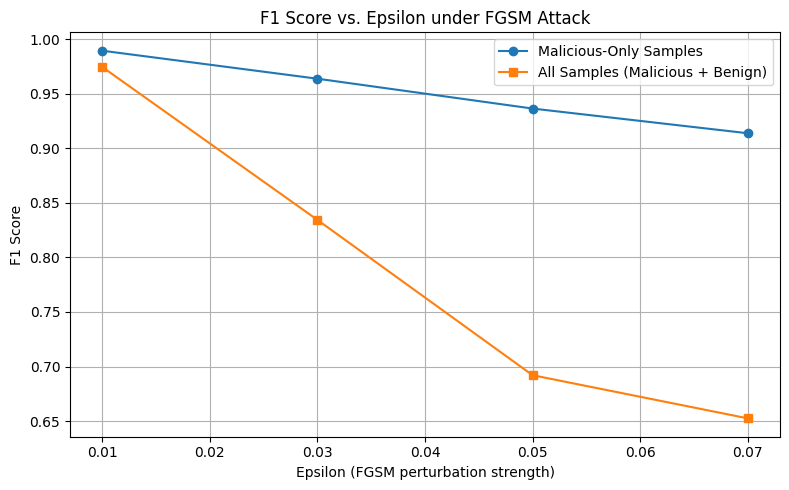

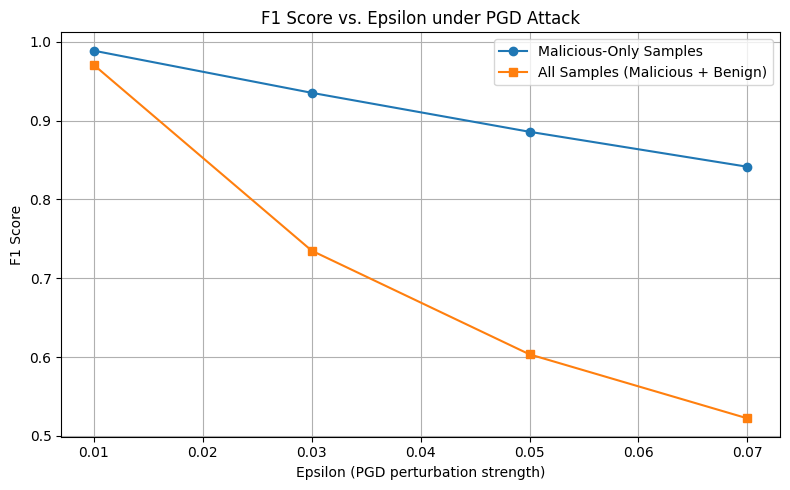

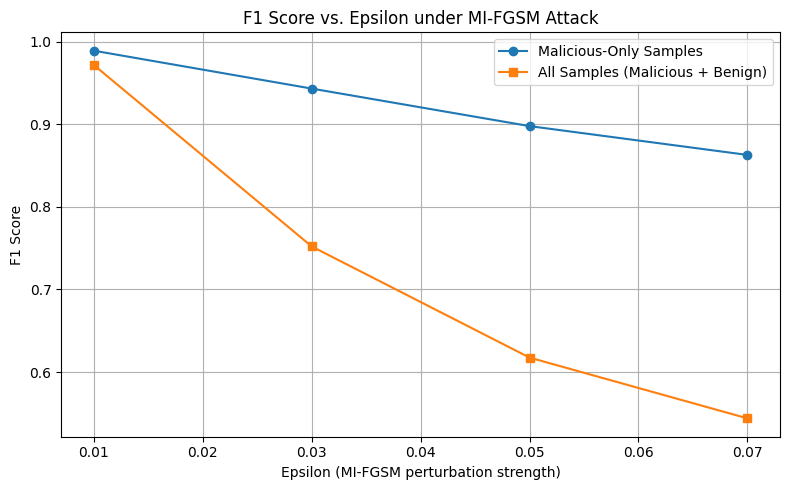

In [25]:
import matplotlib.pyplot as plt

def plot_results(f1_malicious_list, f1_all_list, epsilons, a_type="PGD"):
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, f1_malicious_list, marker='o', label='Malicious-Only Samples')
    plt.plot(epsilons, f1_all_list, marker='s', label='All Samples (Malicious + Benign)')
    plt.xlabel(f"Epsilon ({a_type} perturbation strength)")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs. Epsilon under {a_type} Attack")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

epsilons = [0.01, 0.03, 0.05, 0.07]

# plot the fgsm curve
f1_malicious_scores = [entry['adversarial']['f1'] for entry in fgsm_mal]
f1_all_scores = [entry['adversarial']['f1'] for entry in fgsm_full]
plot_results(f1_malicious_scores, f1_all_scores, epsilons=epsilons, a_type='FGSM')


# plot the PGD Curve
f1_malicious_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_mal]
f1_all_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_full]

plot_results(f1_malicious_scores_pgd, f1_all_scores_pgd, epsilons=epsilons, a_type='PGD')

# MI-FGSM Plot
f1_malicious_scores_mi = [entry['adversarial']['f1'] for entry in mi_mal]
f1_all_scores_mi = [entry['adversarial']['f1'] for entry in mi_full]

plot_results(f1_malicious_scores_mi, f1_all_scores_mi, epsilons=epsilons, a_type='MI-FGSM')